In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import check_random_state
from gplearn.genetic import SymbolicRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

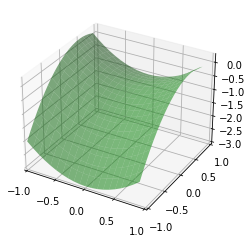

In [4]:
x0 = np.arange(-1, 1, 1/10.)
x1 = np.arange(-1, 1, 1/10.)
x0, x1 = np.meshgrid(x0, x1) #网格化，即生成一个二维矩阵
y_truth = x0**2 - x1**2 + x1 - 1

ax = plt.figure().add_subplot(projection='3d')
ax.set_xlim(-1, 1) #横轴的范围
ax.set_ylim(-1, 1)
surf = ax.plot_surface(x0, x1, y_truth, rstride=1, cstride=1, #3d绘图
                       color='green', alpha=0.5) #rstride表示行的步长，这里是1
plt.show()

In [5]:
rng = check_random_state(0)  #创造一个该seed下的randomstate新实例
# Training samples
X_train = rng.uniform(-1, 1, 100).reshape(50, 2)  #均匀分布随机产生
y_train = X_train[:, 0]**2 - X_train[:, 1]**2 + X_train[:, 1] - 1
# Testing samples
X_test = rng.uniform(-1, 1, 100).reshape(50, 2)
y_test = X_test[:, 0]**2 - X_test[:, 1]**2 + X_test[:, 1] - 1
function_set = ['add', 'sub', 'mul', 'div']  #符号集合
est_gp = SymbolicRegressor(population_size=5000,
                           generations=20,
                           stopping_criteria=0.01,  #将演化20代，除非误差小于该值了
                           function_set=function_set,
                           p_crossover=0.7, p_subtree_mutation=0.1,  #交叉和子树变异概率
                           p_hoist_mutation=0.05, p_point_mutation=0.1, #hoist突变概率（抗膨胀）, point突变概率（直接改变节点信息）
                           max_samples=0.9, verbose=1, #从样本X中抽取的比例来评估程序   后者表示输出最佳程序中的 out of bag适应度
                           parsimony_coefficient=0.01, random_state=0) #前者控制膨胀现象，值越大，惩罚越重，模型越可能欠拟合，但计算量更小
est_gp.fit(X_train, y_train)
print(est_gp._program)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    38.13          458.578        5         0.320666         0.556764      1.81m
   1     9.97          1.70233        5         0.320202         0.624787      1.30m
   2     7.72          1.94456       11         0.239537         0.533148      1.09m
   3     5.41         0.990157        7         0.235676         0.719906     54.62s
   4     4.66         0.894443       11         0.103946         0.103946     52.56s
   5     5.41         0.940242       11         0.060802         0.060802     45.85s
   6     6.78          1.09536       11      0.000781474      0.000781474     42.59s
sub(add(-0.999, X1), mul(sub(X1, X0), add(X0, X1)))


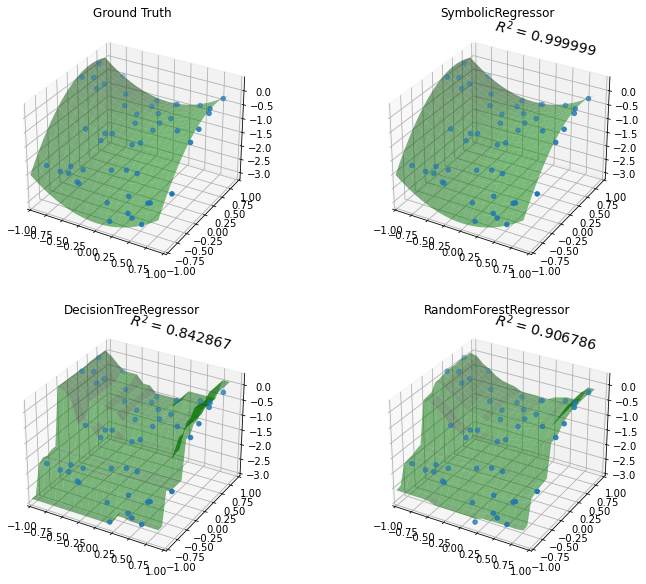

In [8]:
est_tree = DecisionTreeRegressor()
est_tree.fit(X_train, y_train)
est_rf = RandomForestRegressor()
est_rf.fit(X_train, y_train)

y_gp = est_gp.predict(np.c_[x0.ravel(), x1.ravel()]).reshape(x0.shape)  #np.c_表示把矩阵进行连接。ravel是把矩阵展开，和flatten功能一样，只是前者返回的是视图，后者返回的是一个拷贝
score_gp = est_gp.score(X_test, y_test)
y_tree = est_tree.predict(np.c_[x0.ravel(), x1.ravel()]).reshape(x0.shape)
score_tree = est_tree.score(X_test, y_test)
y_rf = est_rf.predict(np.c_[x0.ravel(), x1.ravel()]).reshape(x0.shape)
score_rf = est_rf.score(X_test, y_test)


fig = plt.figure(figsize=(12, 10))

for i, (y, score, title) in enumerate([(y_truth, None, "Ground Truth"), #enumerate将一个可遍历的数据对象组合为一个索引序列，同时列出数据和数据下标
                                       (y_gp, score_gp, "SymbolicRegressor"),
                                       (y_tree, score_tree, "DecisionTreeRegressor"),
                                       (y_rf, score_rf, "RandomForestRegressor")]):

    ax = fig.add_subplot(2, 2, i+1, projection='3d')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    surf = ax.plot_surface(x0, x1, y, rstride=1, cstride=1, color='green', alpha=0.5)
    points = ax.scatter(X_train[:, 0], X_train[:, 1], y_train)
    if score is not None:
        score = ax.text(-.7, 1, .2, "$R^2 =\/ %.6f$" % score, 'x', fontsize=14)
    plt.title(title)
plt.show()


In [1]:
import graphviz
dot_data = est_gp._program.export_graphviz()
graph = graphviz.Source(dot_data)
graph

NameError: name 'est_gp' is not defined

In [15]:
print(est_gp._program.parents)

{'method': 'Crossover', 'parent_idx': 1555, 'parent_nodes': range(1, 4), 'donor_idx': 78, 'donor_nodes': []}


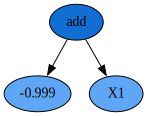

In [26]:
idx = est_gp._program.parents['donor_idx']
fade_nodes = est_gp._program.parents['donor_nodes']
dot_data = est_gp._programs[-2][idx].export_graphviz(fade_nodes=fade_nodes)
graph = graphviz.Source(dot_data)
graph

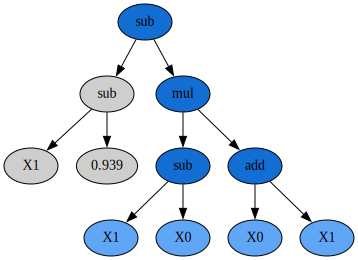

In [29]:
idx = est_gp._program.parents['parent_idx']
dot_data = est_gp._programs[-2][idx].export_graphviz(fade_nodes=fade_nodes)
graph = graphviz.Source(dot_data)
graph